# LOAD LIBRARIES

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

# CONFIGURATION

In [11]:
START_DATE, END_DATE = '2022-09-01', '2023-10-05'
TIME_RESOLUTION = '4'
TARGET_FLUX = 'n2o'
QUALITY_FLAG = 'qcf0'
N_FOLDS = 10
MODEL_TYPE = 'XGBoost'  # Options: 'RandomForest' or 'XGBoost'
CROSSVAL_SPLIT = 'time_blocks_eliza' # options: 'shuffle' or 'kfold' or 'time_blocks_eliza'
LOG_TRANSFORM = True
ADD_ID = False
UNDERSAMPLE = True
PERMUTATION_SEL = False
RFE_SEL = True

# LOAD DATA

In [ ]:
data = pd.read_csv(f'../data/processed/DRIVERS_dataset_{TIME_RESOLUTION}h.csv', low_memory=False)
data['timestamp_middle'] = pd.to_datetime(data['timestamp_middle'])
data.set_index('timestamp_middle', inplace=True)
data = data.loc[START_DATE:END_DATE]

# Add an id column to account for the proximity of values as the timestamp is continuous without gaps
if ADD_ID:
    data['id'] = range(0, len(data))

# CLEAN DATA

In [13]:
TARGET = f'flux_{TARGET_FLUX}_{QUALITY_FLAG}'

median_nan_size = (
    data[TARGET]
    .isna()
    .ne(data[TARGET].isna().shift())
    .cumsum()
    .where(data[TARGET].isna())
    .dropna()
    .value_counts()
    .median()
)
print("Median size of consecutive NaNs in the target variable:", median_nan_size)

# Remove NAs
data = data[data[TARGET].notna()]

# Keep only variables of the chosen categories
prefix = ('wfps', 'ts', 'prec', 'flux_gpp', 'n_decay_timed', 'timesince_fert', 'timesince_soil_preparation', 'timesince_harvest', f'flux_{TARGET_FLUX}')
to_keep = [c for c in data.columns if c.startswith(prefix) and '0.5' not in c]
data = data[to_keep].copy()

# Remove any flux variable with target flux except for the target itself
to_drop = [col for col in data.columns if TARGET_FLUX in col]
# Leave the target!
to_drop.remove(TARGET)
data.drop(columns=to_drop, inplace=True)

def clean_data(df, threshold=0.05):
    """Remove columns with too many missing values and non-numeric columns."""
    dropped_missing = df.columns[df.isna().mean() > threshold].tolist()
    df = df.drop(columns=dropped_missing)
    dropped_non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
    df = df.select_dtypes(include=[np.number])
    print(f"Dropped {len(dropped_missing)} due to missing values: {dropped_missing}")
    print(f"Dropped {len(dropped_non_numeric)} non-numeric columns: {dropped_non_numeric}")
    
    return df

data = clean_data(data)

data

Median size of consecutive NaNs in the target variable: 3.0
Dropped 0 due to missing values: []
Dropped 0 non-numeric columns: []


,flux_n2o_qcf0,flux_gpp,prec,ts_0.05,ts_0.15,ts_0.3,wfps_0.05,wfps_0.15,wfps_0.3,n_decay_timed,...,ts_0.3_diff48h,wfps_0.05_diff12h,wfps_0.05_diff24h,wfps_0.05_diff48h,wfps_0.15_diff12h,wfps_0.15_diff24h,wfps_0.15_diff48h,wfps_0.3_diff12h,wfps_0.3_diff24h,wfps_0.3_diff48h
timestamp_middle,,,,,,,,,,,,,,,,,,,,,
2022-09-01 04:00:00,0.242429,3.077580,0.0,17.577569,19.104306,19.170764,29.051775,22.108163,31.018332,0.0,...,-0.404792,-1.062558,1.028308,1.704769,-0.303753,-0.094928,-0.469126,-0.077292,0.166907,-0.231051
2022-09-01 08:00:00,-0.020742,18.406707,0.0,18.016180,18.734653,18.886667,28.948170,21.917521,30.969499,0.0,...,-0.436319,-0.646453,0.102948,2.387247,-0.499575,-0.485645,-0.278392,-0.165390,0.181054,-0.259238
2022-09-01 12:00:00,-0.233794,18.004702,0.0,20.296944,18.839792,18.705625,29.102167,21.751624,30.864144,0.0,...,-0.582570,-0.193133,-1.307600,-0.683744,-0.561318,-0.651114,-0.275279,-0.225380,-0.100895,-0.249998
2022-09-01 16:00:00,-0.255840,3.493765,0.0,20.577500,19.362084,18.816319,28.973410,21.744950,30.870654,0.0,...,-0.802569,-0.078365,-1.140923,-0.501322,-0.363214,-0.666967,-0.348724,-0.147678,-0.224971,-0.271450
2022-09-02 08:00:00,-0.265809,21.663946,0.0,17.921111,17.912916,18.202083,28.208974,21.083679,30.704594,0.0,...,-1.271945,-0.358983,-0.739196,-0.636248,-0.657767,-0.833842,-1.319487,-0.195572,-0.264905,-0.083852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-03 20:00:00,0.904912,1.391552,0.0,15.964653,16.568125,16.170069,35.452801,53.681349,53.224239,0.0,...,-0.018889,-0.810702,-0.677960,-2.364172,-0.163795,-0.529972,-0.915471,-0.127161,-0.317963,-0.554744
2023-10-04 08:00:00,0.781407,1.531960,0.0,14.847847,15.841875,15.936528,35.261959,53.215485,53.060850,0.0,...,0.116250,-0.190842,-1.001544,-2.417786,-0.465864,-0.629659,-0.944960,-0.163389,-0.290550,-0.505746
2023-10-04 12:00:00,1.360674,1.279627,0.0,15.727778,15.859306,15.817709,33.884309,53.178821,52.927896,0.0,...,0.090556,-1.547875,-1.319816,-2.506386,-0.356637,-0.569158,-1.025921,-0.269625,-0.314303,-0.559491


# IMBALANCE HANDLING

## UNDER SAMPLING

Undersampling target data below: 1.0789741386666667


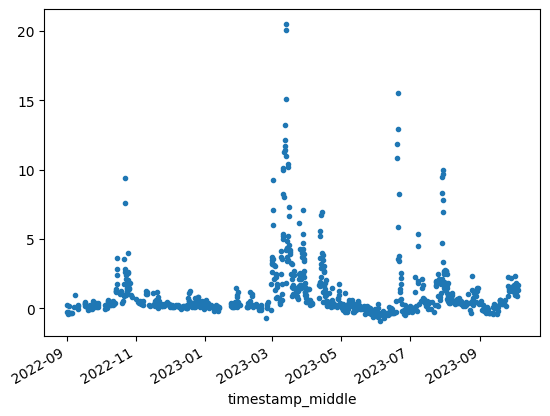

In [14]:
if UNDERSAMPLE:
    quantile_cutoff = 0.8
    cutoff_value = data[TARGET].quantile(quantile_cutoff)
    print(f'Undersampling target data below: {cutoff_value}')
    # Split and undersample
    upper = data[data[TARGET] > cutoff_value]
    lower = data[data[TARGET] <= cutoff_value]
    # Undersample
    lower_sampled = lower.sample(frac=0.5, random_state=42)
    # Combine
    data = pd.concat([upper, lower_sampled]).sample(frac=1, random_state=42)
    # Resort data
    data = data.sort_index().reset_index(drop=False)  # keep the timestamp as a column
    data = data.set_index('timestamp_middle')    # and set it back as index if needed
    # Plot
    data[TARGET].plot(x_compat=True, style='.');

## LOG TRANSFORMATION

The target was log transformed


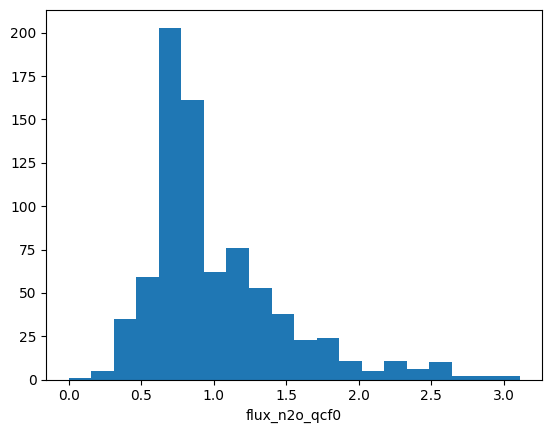

,flux_n2o_qcf0,flux_gpp,prec,ts_0.05,ts_0.15,ts_0.3,wfps_0.05,wfps_0.15,wfps_0.3,n_decay_timed,...,ts_0.3_diff48h,wfps_0.05_diff12h,wfps_0.05_diff24h,wfps_0.05_diff48h,wfps_0.15_diff12h,wfps_0.15_diff24h,wfps_0.15_diff48h,wfps_0.3_diff12h,wfps_0.3_diff24h,wfps_0.3_diff48h
timestamp_middle,,,,,,,,,,,,,,,,,,,,,
2022-09-01 04:00:00,0.756479,3.077580,0.0,17.577569,19.104306,19.170764,29.051775,22.108163,31.018332,0.0,...,-0.404792,-1.062558,1.028308,1.704769,-0.303753,-0.094928,-0.469126,-0.077292,0.166907,-0.231051
2022-09-01 12:00:00,0.503521,18.004702,0.0,20.296944,18.839792,18.705625,29.102167,21.751624,30.864144,0.0,...,-0.582570,-0.193133,-1.307600,-0.683744,-0.561318,-0.651114,-0.275279,-0.225380,-0.100895,-0.249998
2022-09-01 16:00:00,0.490107,3.493765,0.0,20.577500,19.362084,18.816319,28.973410,21.744950,30.870654,0.0,...,-0.802569,-0.078365,-1.140923,-0.501322,-0.363214,-0.666967,-0.348724,-0.147678,-0.224971,-0.271450
2022-09-02 12:00:00,0.374641,12.475740,0.0,22.167222,18.617500,18.139514,28.670670,21.060803,30.600884,0.0,...,-1.232709,0.328727,-0.431497,-1.739097,-0.527953,-0.690822,-1.341935,-0.247245,-0.263260,-0.364155
2022-09-03 08:00:00,0.721050,13.819019,0.8,18.338403,18.423125,18.332152,27.571441,21.185045,30.425034,0.0,...,-0.554514,-0.403872,-0.637534,-1.376730,-0.037089,0.101366,-0.732476,-0.347464,-0.279560,-0.544465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-03 12:00:00,1.278283,1.199078,0.0,16.641042,16.086875,15.882569,35.204124,53.747979,53.242199,0.0,...,-0.062153,-1.114769,-1.186570,-2.749784,-0.273381,-0.456763,-0.887349,-0.291414,-0.245187,-0.551847
2023-10-03 16:00:00,1.204291,-1.678386,0.1,16.734583,16.506250,16.011320,35.262709,53.714661,53.250844,0.0,...,-0.012569,-1.047348,-0.627493,-2.325930,-0.147620,-0.563543,-0.960738,-0.187378,-0.241107,-0.519952
2023-10-03 20:00:00,1.027203,1.391552,0.0,15.964653,16.568125,16.170069,35.452801,53.681349,53.224239,0.0,...,-0.018889,-0.810702,-0.677960,-2.364172,-0.163795,-0.529972,-0.915471,-0.127161,-0.317963,-0.554744


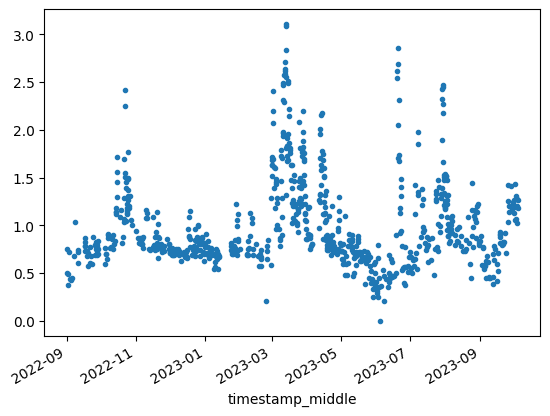

In [ ]:
min_value = data[TARGET].min()

def log_transform(x):
    return np.log1p(x - min_value) if min_value < 0 else np.log1p(x)

def inverse_log_transform(x):
    return np.expm1(x) + min_value if min_value < 0 else np.expm1(x)

if LOG_TRANSFORM:
    data[TARGET] = log_transform(data[TARGET])
    print('The target was log transformed')
    # Show histogram of TARGET
    plt.hist(data[TARGET], bins=20)
    plt.xlabel(TARGET)
    plt.show()
    # Show timeseries
    data[TARGET].plot(x_compat=True, style='.');

# CROSS-VAL SPLITS

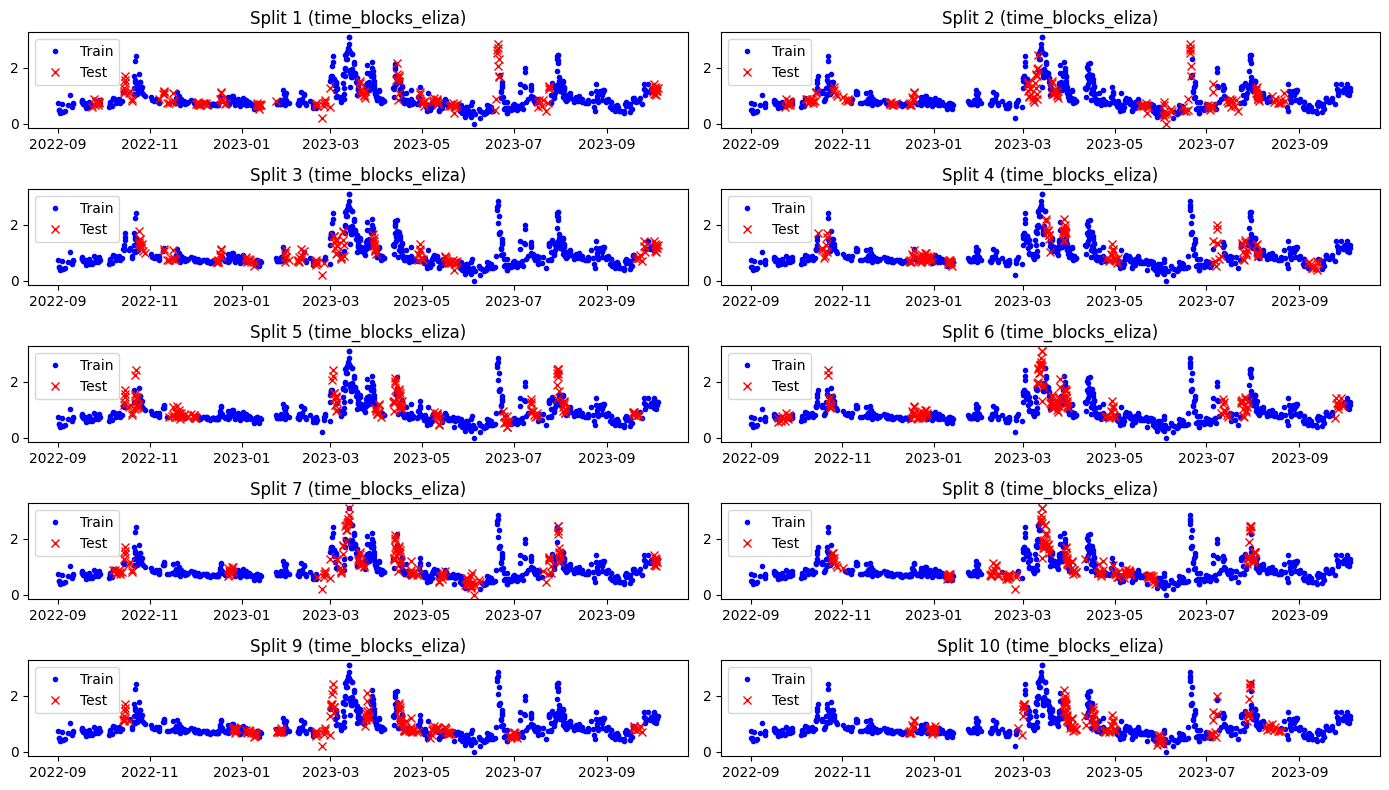

In [16]:
def create_splits(X, y, n_folds, test_size=0.2, random_state=42, n_bins=5):
    """Creates train-test splits using StratifiedShuffleSplit or StratifiedKFold with equal-width binning."""
    
    # Use pd.cut to create equal-width bins (avoids empty bins issue)
    y_binned = pd.cut(y, bins=n_bins, labels=False, include_lowest=True)

    # Select method for stratified splitting
    if CROSSVAL_SPLIT == "shuffle":
        splitter = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=random_state)
    elif CROSSVAL_SPLIT == "kfold":
        splitter = StratifiedKFold(n_splits=n_folds, shuffle=False)

    # Generate train-test splits
    splits = [(train_idx, test_idx) for train_idx, test_idx in splitter.split(X, y_binned)]

    return splits

if CROSSVAL_SPLIT == 'time_blocks_eliza':
    def create_splits(X, y, n_folds, split=0.2, mean_block=10, min_block=5, random_state=42): # you can set mean block to median_nan_size
        """Generates multiple train-test index splits using block-based cross-validation by varying the random seed."""
        splits = []
        total_test = round(len(X) * split)
        n_blocks = round(total_test/mean_block)

        if mean_block < min_block:
            raise ValueError("Min block size is too large for the number of blocks.")

        for fold in range(n_folds):
            np.random.seed(random_state + fold)  # Change seed for each fold
            
            tt = np.zeros(len(X))  # Array to store train-test assignments

            # Generate random block sizes with normal variation
            blocks = np.array([max(min_block, mean_block + round(v)) 
                            for v in np.random.normal(0, mean_block / 10, n_blocks)])

            # Randomly shuffle the starting positions of test blocks
            available_positions = np.arange(len(X))  # Possible start positions
            np.random.shuffle(available_positions)   # Shuffle them

            # Assign blocks sequentially based on shuffled positions
            assigned = set()
            for b in blocks:
                if len(assigned) >= total_test:
                    break
                # Pick a random starting position
                istart = np.random.choice(available_positions)
                iend = min(istart + int(b), len(X))

                # Ensure blocks don't overlap significantly
                assigned.update(range(istart, iend))
                tt[istart:iend] = 1

            train_idx = np.where(tt == 0)[0]
            test_idx = np.where(tt == 1)[0]
            
            splits.append((train_idx, test_idx))

        return splits

X = data.drop(columns=TARGET)
y = data[TARGET]
# Create the splits using StratifiedShuffleSplit
cross_val_splits = create_splits(X, y, n_folds=N_FOLDS)


# --- PLOT TRAIN-TEST SPLITS ---
n_rows = math.ceil(N_FOLDS / 2)  # Ensure enough rows for all splits
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 8))
axes = axes.flatten()  # Flatten the axes array to make iteration easier

for i, (train_idx, test_idx) in enumerate(cross_val_splits):
    train_idx_mapped = X.iloc[train_idx].index
    test_idx_mapped = X.iloc[test_idx].index

    # Plot train and test points
    axes[i].plot(y.loc[train_idx_mapped].index, y.loc[train_idx_mapped], '.', label='Train', color="blue")
    axes[i].plot(y.loc[test_idx_mapped].index, y.loc[test_idx_mapped], 'x', label='Test', color="red")
    
    axes[i].set_title(f"Split {i + 1} ({CROSSVAL_SPLIT})")
    axes[i].legend()

# Hide unused subplots if n_folds is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# FEATURE SELECTION

## Permutation importance

In [17]:
N_REPEATS = 5
N_RANDOMS = 10 
def permutation_importance_selection(X, y, n_repeats=N_REPEATS, n_randoms=N_RANDOMS):
    iteration = 0

    # Generate random features ONCE and keep them throughout the iterations
    np.random.seed(42)  # Ensures reproducibility
    for i in range(n_randoms):
        X[f'random_{i}'] = np.random.permutation(len(X))

    while True:
        iteration += 1
        print(f"Iteration {iteration}: Starting with {X.shape[1] - n_randoms} features")

        model = RandomForestRegressor(n_estimators=100, min_samples_split=10, min_samples_leaf=5, random_state=42, n_jobs=-1) \
            if MODEL_TYPE == 'RandomForest' else XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        importance_scores, rmse_scores, r2_scores = [], [], []

        for train_idx, test_idx in cross_val_splits:
            X_train, y_train, X_test, y_test = X.iloc[train_idx], y.iloc[train_idx], X.iloc[test_idx], y.iloc[test_idx]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Invert the transformation if it was applied to calculate the performance with the original scale
            if LOG_TRANSFORM:
                y_test, y_pred = inverse_log_transform(y_test), inverse_log_transform(y_pred)

            perm_importance = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, random_state=42, n_jobs=-1)
            importance_scores.append(perm_importance.importances_mean)
            rmse_scores.append(root_mean_squared_error(y_test, y_pred))
            r2_scores.append(r2_score(y_test, y_pred))

        mean_importance = np.mean(importance_scores, axis=0)
        threshold = np.mean(mean_importance[-n_randoms:])  # Use average of random features as threshold
        
        to_remove = [col for col in X.columns if mean_importance[X.columns.get_loc(col)] < threshold and not col.startswith('random_')]
        to_keep = [col for col in X.columns if col not in to_remove]
        print(f"Iteration {iteration}: Removed {len(to_remove)} features, RMSE: {np.mean(rmse_scores):.4f}, R²: {np.mean(r2_scores):.4f}")
        
        if len(to_remove) == 0:
            break  # Stop when no features are removed

        X = X[to_keep].copy()

    # Remove random features from final selection
    to_keep = [col for col in to_keep if not col.startswith('random_')]
    return to_keep


if PERMUTATION_SEL:
    to_keep = permutation_importance_selection(data.drop(columns=[TARGET]), data[TARGET])
    data = data[to_keep + [TARGET]]
    to_keep

## Recursive feature elimination

In [18]:
def rfe_selection(X, y, cross_val_splits):
    performance = []
    iteration = 0
    features = list(X.columns)
    feature_removal_order = []  # Store removed features and their iteration index

    while len(features) > 1:
        iteration += 1
        rmse_scores, r2_scores, importances = [], [], []

        for train_idx, test_idx in cross_val_splits:
            X_train, y_train, X_test, y_test = X[features].iloc[train_idx], y.iloc[train_idx], X[features].iloc[test_idx], y.iloc[test_idx]
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) if MODEL_TYPE == 'RandomForest' else XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Invert the transformation if it was applied to calculate the performance with the original scale
            if LOG_TRANSFORM:
                y_test, y_pred = inverse_log_transform(y_test), inverse_log_transform(y_pred)
            
            rmse_scores.append(root_mean_squared_error(y_test, y_pred))
            r2_scores.append(r2_score(y_test, y_pred))
            importances.append(model.feature_importances_)

        mean_rmse = np.mean(rmse_scores)
        mean_r2 = np.mean(r2_scores)
        performance.append((features.copy(), mean_rmse, mean_r2))

        mean_importances = np.mean(importances, axis=0)
        least_important_index = np.argmin(mean_importances)
        least_important_feature = features.pop(least_important_index)

        # Store the removed feature with its iteration index
        feature_removal_order.append((least_important_feature, iteration))

        print(f"Iteration {iteration}: Remaining features: {len(features)}, Removed: {least_important_feature}, RMSE: {mean_rmse:.4f}, R²: {mean_r2:.4f}")

    # Extract RMSE and R² values
    rmse_values = [score[1] for score in performance]
    r2_values = [score[2] for score in performance]

    # Plot RMSE and R² over iterations
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    axs[0].plot(range(len(performance)), rmse_values, label="Cross-validated RMSE")
    axs[0].set_ylabel("RMSE")
    axs[0].legend()

    axs[1].plot(range(len(performance)), r2_values, label="Cross-validated R²", color="orange")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("R²")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Select best feature set by minimizing both R² and RMSE and penlizing larger feature sets
    # Normalize RMSE and R²
    norm_rmse = (np.array(rmse_values) - min(rmse_values)) / (max(rmse_values) - min(rmse_values))
    norm_r2 = (np.array(r2_values) - min(r2_values)) / (max(r2_values) - min(r2_values))
    # Set weights for normalized metrics
    w_rmse, w_r2, w_penalty = 0.5, 0.5, 0.01  # Adjust w_penalty as needed
    # Calculate composite scores with normalized metrics and feature count penalty
    composite_scores = [
        (performance[i][0], # Features
         i + 1, # Iteration number
        w_rmse * norm_rmse[i] + w_r2 * (1 - norm_r2[i]) + w_penalty * len(performance[i][0])  # Composite score
        )  
        for i in range(len(performance))
    ]

    # Find the feature subset with the best (lowest) composite score
    best_features, best_iteration, _ = min(composite_scores, key=lambda x: x[2])

    # Add the final remaining feature
    feature_removal_order.append((features[0], iteration + 1))

    # Rank features based on removal order
    feature_ranking = [feature for feature, _ in sorted(feature_removal_order, key=lambda x: x[1], reverse=True)]

    # Print the best feature set details
    print(f"\nBest feature set found at iteration {best_iteration}:")
    print(f"Selected Features: {best_features}")
    print(f"Performance - RMSE: {rmse_values[best_iteration-1]:.4f}, R²: {r2_values[best_iteration-1]:.4f}")

    return best_features, feature_ranking

if RFE_SEL:
    selected_features, ranked_features = rfe_selection(data.drop(columns=[TARGET]), data[TARGET], cross_val_splits= cross_val_splits)
    # Update the main dataframe
    data = data[selected_features + [TARGET]]

Iteration 1: Remaining features: 77, Removed: prec_lag48h, RMSE: 2.0651, R²: 0.1680
Iteration 2: Remaining features: 76, Removed: ts_0.15_diff12h, RMSE: 2.0478, R²: 0.1919
Iteration 3: Remaining features: 75, Removed: flux_gpp_lag12h, RMSE: 2.0511, R²: 0.1591
Iteration 4: Remaining features: 74, Removed: ts_0.3_diff12h, RMSE: 2.0458, R²: 0.1648


KeyboardInterrupt: 

# EXPORT 

In [ ]:
filename = '../data/processed/best_features_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.txt'
with open(filename, 'w') as f:
    for item in selected_features:
        f.write(f"{item}\n")

filename = '../data/processed/ranked_features_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.txt'
with open(filename, 'w') as f:
    for item in ranked_features:
        f.write(f"{item}\n")

NameError: name 'selected_features' is not defined

# **End of notebook**

In [20]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2025-12-12 16:38:32
